### Simulation

# Homogeneous Temporal Point Process

In [33]:
import numpy as np

def sample_exponential_numpy(lambda_rate):
    return np.random.exponential(1 / lambda_rate)

def sample_exponential_inverse_transform(lambda_rate):
    u = np.random.uniform(0, 1)
    return -np.log(1 - u) / lambda_rate

def sample_exponential_discretization(lambda_rate, dt=0.01):
    t = 0
    while True:
        t += dt
        if np.random.uniform(0, 1) < lambda_rate * dt:
            return t
        
def sample_exponential_rescale(lambda_rate):
    sample = np.random.exponential(1)
    return sample / lambda_rate

In [34]:
def sample_homogeneous_point_process(h = 10.0, lambda_rate = 1.0):
    # Input: time horizon h > 0, rate lambda > 0
    # Output: list of event times
    events = []
    t = 0
    while t < h:
        # Generate the time to the next event using the exponential distribution
        # !!! In Numpy, the exponential distribution is parameterized with the mean, not the rate. !!!
        delta_t = sample_exponential_numpy(lambda_rate)
        t += delta_t # Update the current time
        if t < h:     # If the updated time is within the time horizon, add it to the list
            events.append(t)
    return events

# Example usage:
time_horizon = 10  # Time horizon h > 0
rate_lambda = 2    # Rate lambda > 0
sample = sample_homogeneous_point_process(time_horizon, rate_lambda)
print("Sampled event times:", sample)


Sampled event times: [0.32744435665597654, 0.917687012947128, 1.093403296006017, 1.3095450376010427, 1.4130693428187466, 1.8264770017243488, 2.0173817564056584, 2.2309604116939115, 3.1312211419421487, 3.1557577860365575, 3.4797870275278324, 3.9807776019249195, 4.024514419147962, 4.168318110123882, 4.179448850770502, 5.1064479723293985, 5.469258896415391, 5.656430833019427, 5.6603339234688645, 6.946450445813452, 7.6113933158556115, 7.655502374989709, 7.786204947412046, 8.21060692953746, 8.321044349293276, 8.798614368439742, 8.824764545639288, 8.954892034620674]


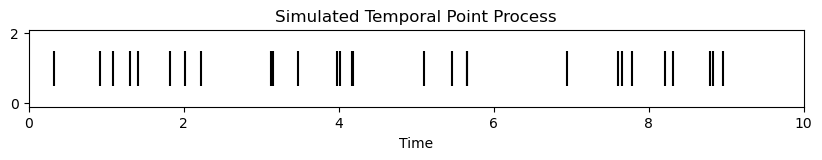

In [35]:
# Plotting the event times
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 1))
plt.eventplot(sample, orientation='horizontal', colors='black')
plt.xlim(0, time_horizon)
plt.xlabel('Time')
plt.title('Simulated Temporal Point Process')
plt.show()


# Non-Homogeneous Temporal Point Process

In [63]:
import numpy as np

def sample_event_time_stepwise(intensity_func, events, h, step_size=0.001):
    t = events[-1] if events else 0
    while True:
        t += step_size
        prob = intensity_func(t, events) * step_size
        if np.random.random() < prob:
            return t
        if t > h:
            return h
        
def sample_event_time_numerical_integration(intensity_func, events, h, step_size=0.001):
    t = events[-1] if events else 0
    while True:
        # Sample the inter-event time from an exponential distribution with rate 1
        delta_t = np.random.exponential(1)
        # Use numerical integration to find the corresponding event time
        cumulative_intensity = 0
        while cumulative_intensity < delta_t:
            t += step_size
            cumulative_intensity += intensity_func(t, events) * step_size
            if t > h:
                return h
        return t

def sample_event_time_poisson(intensity_func, events, h, upper_bound):
    t = events[-1] if events else 0
    while True:
        # Sample candidate event time from exponential distribution with rate upper_bound
        delta_t = np.random.exponential(1 / upper_bound)
        t += delta_t
        if t > h:
            return h
        # Accept the candidate with probability intensity_func(t_candidate, events) / upper_bound
        if np.random.random() < intensity_func(t, events) / upper_bound:
            return t

def sample_inhomogeneous_point_process(h, intensity_func, method='stepwise', upper_bound=None, step_size=0.001):
    # Input: time horizon h > 0, intensity function, sampling method
    # Output: list of event times
    assert upper_bound is None or step_size is None
    events = []
    t = 0
    while t < h:
        if method == 'stepwise':
            t_next = sample_event_time_stepwise(intensity_func, events, h, step_size)
        elif method == 'numerical_integration':
            t_next = sample_event_time_numerical_integration(intensity_func, events, h, step_size)
        elif method == 'poisson':
            t_next = sample_event_time_poisson(intensity_func, events, h, upper_bound)
        else:
            raise ValueError("Unknown method")
        t = t_next
        if t < h:  # If the updated time is within the time horizon, add it to the list
            events.append(t)
    return events

# Example intensity function
def example_intensity_func(t, events):
    # A simple intensity function that increases with the number of past events
    t_last = events[-1] if events else 0
    base_rate = 10.0 if np.abs(t-t_last) < 0.1 else 0.3
    return base_rate 

# Example usage
time_horizon = 10.  # Time horizon h > 0
sample1 = sample_inhomogeneous_point_process(time_horizon, example_intensity_func, method='stepwise', upper_bound=None, step_size=0.0001)
print("Sampled event times (stepwise):", sample)

sample2 = sample_inhomogeneous_point_process(time_horizon, example_intensity_func, method='numerical_integration', upper_bound=None, step_size=0.0001)
print("Sampled event times (numerical integration):", sample)

sample3 = sample_inhomogeneous_point_process(time_horizon, example_intensity_func, method='poisson', upper_bound=10.0, step_size=None)
print("Sampled event times (poisson):", sample)


Sampled event times (stepwise): [0.032366912264502286, 1.1202246042321777, 1.180588830259163, 1.2012656293693762, 3.2468274888302053, 3.3171324522388135, 3.317192283997249, 7.379756434735964, 7.390556281555829, 7.446462602745077, 8.004890368855177, 9.191242587987789, 9.202372062292284, 9.453968500965004, 9.455560216019537, 9.48524353515826, 9.741265282984157, 9.866337001047322]
Sampled event times (numerical integration): [0.032366912264502286, 1.1202246042321777, 1.180588830259163, 1.2012656293693762, 3.2468274888302053, 3.3171324522388135, 3.317192283997249, 7.379756434735964, 7.390556281555829, 7.446462602745077, 8.004890368855177, 9.191242587987789, 9.202372062292284, 9.453968500965004, 9.455560216019537, 9.48524353515826, 9.741265282984157, 9.866337001047322]
Sampled event times (poisson): [0.032366912264502286, 1.1202246042321777, 1.180588830259163, 1.2012656293693762, 3.2468274888302053, 3.3171324522388135, 3.317192283997249, 7.379756434735964, 7.390556281555829, 7.4464626027450

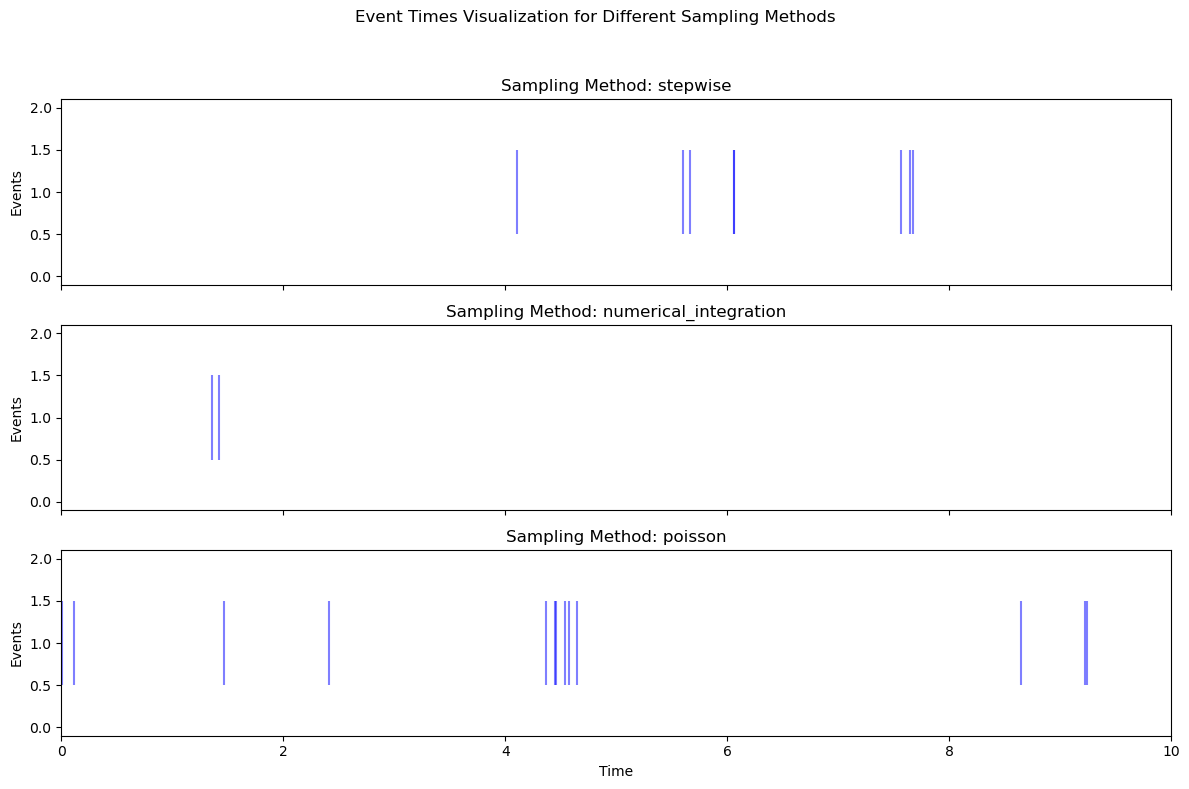

In [68]:
# Visualization
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle('Event Times Visualization for Different Sampling Methods')

for ax, sample, method in zip(axs, [sample1, sample2, sample3], ["stepwise", "numerical_integration", "poisson"]):
    ax.eventplot(sample, orientation='horizontal', colors='blue', alpha=0.5)
    #ax.scatter(sample, np.zeros_like(sample), edgecolor='blue', facecolor='none', alpha=0.5)
    ax.set_title(f'Sampling Method: {method}')
    ax.set_xlim(0, time_horizon)
    ax.set_ylabel('Events')

axs[-1].set_xlabel('Time')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Spatio-Temporal Point Process

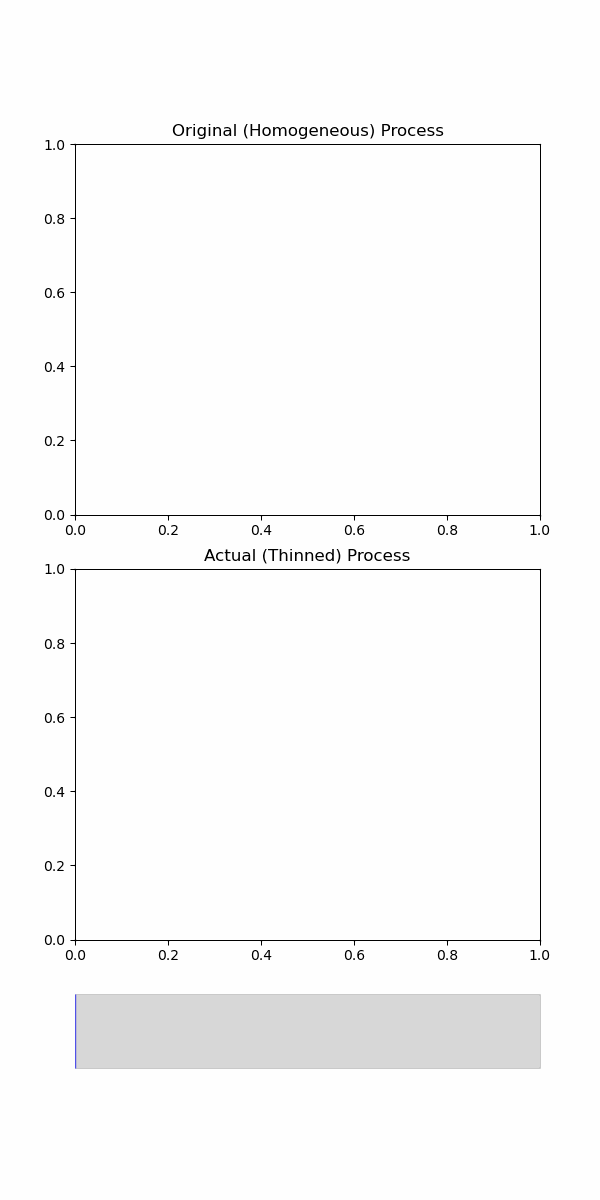

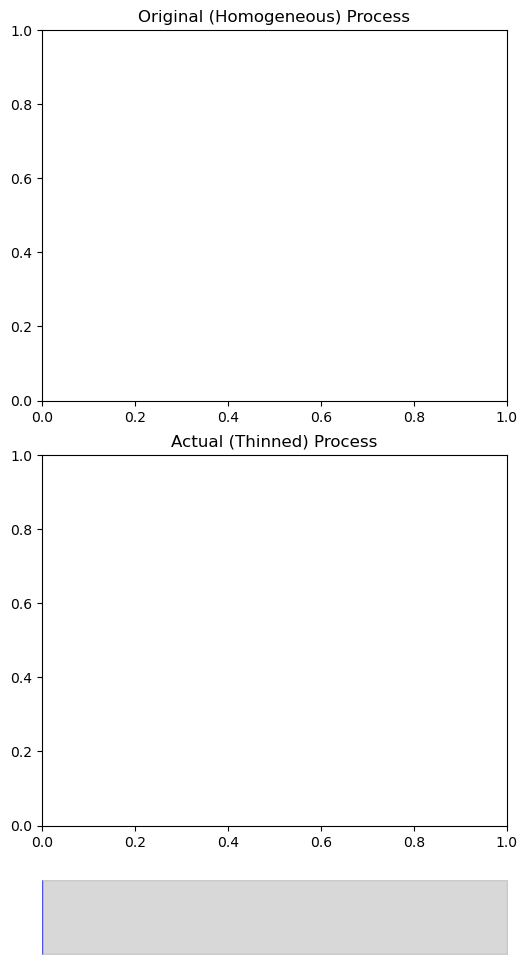

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image as IPImage

def sample_event_time(rate_max):
    return np.random.exponential(1 / rate_max)

def sample_event_position(space):
    return [np.random.uniform(low, high) for low, high in space]

def thinning_algorithm(rate_max, intensity_func, time_horizon, space=[[0, 1], [0, 1]]):
    original_events = []
    thinned_events = []
    t = 0
    while t < time_horizon:
        t_candidate = t + sample_event_time(rate_max)
        if t_candidate >= time_horizon:
            break
        position_candidate = sample_event_position(space)
        original_events.append((t_candidate, position_candidate))
        if np.random.random() < intensity_func(t_candidate, thinned_events, position_candidate) / rate_max:
            thinned_events.append((t_candidate, position_candidate))
        t = t_candidate
    return original_events, thinned_events

def example_intensity_func(t, events, position, base_rate=2.0, alpha=1.5, beta=1.0, spatial_sigma=0.1):
    intensity = base_rate
    for event_time, event_position in events:
        time_diff = t - event_time
        if time_diff > 0:
            temporal_component = alpha * np.exp(-beta * time_diff)
            spatial_component = np.exp(-np.sum((np.array(position) - np.array(event_position))**2) / (2 * spatial_sigma**2))
            intensity += temporal_component * spatial_component
    return min(intensity, rate_max)

# Simulation parameters
time_horizon = 10.0
rate_max = 20.0
space = [[0, 1], [0, 1]]
original_events, thinned_events = thinning_algorithm(rate_max, example_intensity_func, time_horizon, space)

# Visualization
fig, (ax1, ax2, ax_progress) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [5, 5, 1]}, figsize=(6, 12))
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax_progress.set_xlim(0, time_horizon)
ax_progress.set_ylim(0, 1)
ax_progress.axis('off')

def animate(i):
    current_time = (i / 10)
    ax1.clear()
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_title('Original (Homogeneous) Process')
    # Draw the original events
    for t, (time, pos) in enumerate(original_events):
        if time <= current_time:
            alpha = max(0, 1 - (current_time - time) / 2)  # Fade out faster
            circle = plt.Circle(pos, 0.02, edgecolor='blue', facecolor='none', alpha=alpha)
            ax1.add_patch(circle)

    ax2.clear()
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.set_title('Actual (Thinned) Process')
    # Draw the thinned events
    for t, (time, pos) in enumerate(thinned_events):
        if time <= current_time:
            alpha = max(0, 1 - (current_time - time) / 2)  # Fade out faster
            circle = plt.Circle(pos, 0.02, edgecolor='blue', facecolor='none', alpha=alpha)
            ax2.add_patch(circle)

    # Draw the progress bar
    ax_progress.clear()
    ax_progress.set_xlim(0, time_horizon)
    ax_progress.set_ylim(0, 1)
    ax_progress.fill_between([0, time_horizon], [0, 0], [1, 1], color='gray', alpha=0.3)
    ax_progress.fill_between([0, current_time], [0, 0], [1, 1], color='blue', alpha=0.6)
    ax_progress.axis('off')

ani = animation.FuncAnimation(fig, animate, frames=int(time_horizon * 10), interval=300, repeat=True)  # Slower animation

# Save animation as GIF
ani.save('spatio_temporal_process_comparison.gif', writer='pillow')

# Display the GIF
IPImage(filename='spatio_temporal_process_comparison.gif')
